# Customer Analysis
Cohort Analysis, Retention, Lifetime Value & RFM Analysis using Machine Learning
---

**Analysis:**

Create different cohorts depending on user's creation date and forecast future behaviour.

**Useful links:**
- Step to step guide: https://www.youtube.com/watch?v=s-32u6XdY7c
- What is RFM analysis: https://www.youtube.com/watch?v=guj2gVEEx4s
- Improve Random Forest Hyperparameters: https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d#:~:text=The%20most%20important%20hyper%2Dparameters,MSE%20or%20MAE%20for%20regression)

**Questions to answer:**
- 1. Which customers have the highest top-up probability in the next 30 days.
- 2. Which customers have recently topped up but are unlikely to buy.
- 3. Which customers were predicted to top-up but didnt. 

In [338]:
# Imports and general settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_columns', None)

## Data Wrangling and EDA

In [2]:
# Reading csv file
df = pd.read_csv('../trash/topup.csv' )

In [3]:
df = df[['transactionid', 'aug_created_date', 'clear_txn_method', '$ USD', 'userid', 'User_Creation_Date']]

In [4]:
df.columns = ['txn_id', 'txn_date', 'txn_type', 'amount_usd', 'user_id', 'user_date']

In [5]:
df.head(3)

,txn_id,txn_date,txn_type,amount_usd,user_id,user_date
0,b1334598-970a-4936-a535-818689761705,2022-10-27 00:00:00,MPESA load,12.42,b74a52e3-4160-933d-c653-644c3826e1bb,2022-09-18 00:00:00
1,513d6960-b689-424a-970d-9e0f20f36f44,2022-10-27 00:00:00,load using bank card,13.61,86611122-811a-5480-407d-daefaf2a42c2,2022-10-07 00:00:00
2,91d42b18-7e04-4be3-be9d-2b7e6734aa36,2022-10-27 00:00:00,load using bank card,1361.25,4d25ec74-1c5e-6b8e-83c4-f4893bfc7147,2022-09-30 00:00:00


In [6]:
df['txn_date'] = pd.to_datetime(df['txn_date'], format='%Y-%m-%d %H:%M:%S')
df['user_date'] = pd.to_datetime(df['user_date'], format='%Y-%m-%d %H:%M:%S')
df['txn_type'] = df['txn_type'].astype('category')
#df['user_status'] = df['user_status'].astype('category')
df['txn_date_ym'] = df['txn_date'].apply(lambda x: x.to_period('M'))
df['user_date_ym'] = df['user_date'].apply(lambda x: x.to_period('M'))
#df['txn_date_ym'] = df.apply(lambda x: str(x['txn_date'].year) + '-' + ('0' + str(x['txn_date'].month))[-2:], axis=1)
#df['user_date_ym'] = df.apply(lambda x: str(x['user_date'].year) + '-' + ('0' + str(x['user_date'].month))[-2:], axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165614 entries, 0 to 165613
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   txn_id        165614 non-null  object        
 1   txn_date      165614 non-null  datetime64[ns]
 2   txn_type      165614 non-null  category      
 3   amount_usd    165614 non-null  float64       
 4   user_id       165614 non-null  object        
 5   user_date     165614 non-null  datetime64[ns]
 6   txn_date_ym   165614 non-null  period[M]     
 7   user_date_ym  165614 non-null  period[M]     
dtypes: category(1), datetime64[ns](2), float64(1), object(2), period[M](2)
memory usage: 9.0+ MB


In [8]:
ke = df[df['txn_type'] == 'MPESA load']
ae = df[df['txn_type'] == 'load using bank card']

## Cohorts Analysis

### UAE

In [9]:
# For UAE, The highest number of users signup is between 2021-10 and 2022-06
ae[['user_date_ym', 'user_id']].groupby('user_date_ym').count().sort_index().T

user_date_ym,2019-02,2019-03,2019-05,2019-07,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_id,7,38,27,1,3,3,35,294,10,29,68,270,159,349,294,402,718,264,428,514,863,1478,1308,690,472,1358,1773,3635,3892,4692,7455,13335,35386,12546,7387,3367,2057,1831,1721,1612,1289,970


In [10]:
orders_per_user = ae.groupby('user_id')['txn_id'].nunique()
multiple_orders_user = np.sum(orders_per_user > 1) / ae.user_id.nunique()
print('More than half of the customers have made 2 or more orders:', f'{round(100*multiple_orders_user, 2)}%')

More than half of the customers have made 2 or more orders: 60.8%


<AxesSubplot:>

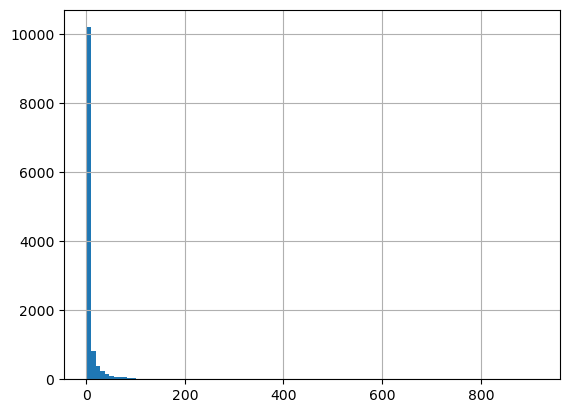

In [11]:
orders_per_user.hist(bins=100)

In [12]:
# Right (Positive) Skewed distribution. Most of the customers performed 5 or less topups.
# There outliers worth investigating such as 1514bdfe-70af-01d8-2df3-748455374d42 with a total of 915 topups.
orders_per_user.sort_values(ascending=False).head()

user_id
1514bdfe-70af-01d8-2df3-748455374d42    915
4ef776d3-97b7-5ce6-ed5b-72bc36b291a1    786
353c1071-d080-af16-e959-ceaaafe66137    528
6712a909-ff60-9aa3-19b7-270721fe21d6    520
dc6409c3-634c-e8b8-de5c-bce69571fb43    422
Name: txn_id, dtype: int64

In [13]:
#ae['cohort'] = ae.groupby('user_id')['user_date'].transform('min').dt.to_period('M')

In [14]:
# create a new column using the agg function. the new column name will be n_customers.
ae_cohort = ae.groupby(['user_date_ym', 'txn_date_ym'])[['user_id']].agg(n_customers=('user_id', 'nunique')) \
                                                                        .reset_index(drop=False)

In [15]:
# This cell and the one below compute the same thing, the number of months between the creation date and transaction date.

#from operator import attrgetter
#ae_cohort['period'] = (ae_cohort.txn_month - ae_cohort.cohort).apply(attrgetter('n'))

In [166]:
# Use period to change the cohort arrangement, every period equals one month here.
ae_cohort['period'] = ae_cohort \
.apply(lambda x: (x.txn_date_ym.year - x.user_date_ym.year) * 12 + (x.txn_date_ym.month  - x.user_date_ym.month), axis=1)

In [167]:
ae_cohort = ae_cohort[(ae_cohort.user_date_ym >= '2022-01') & (ae_cohort.period >= 0)].reset_index(drop=True)

In [168]:
ae_cohort.head(3)

,user_date_ym,txn_date_ym,n_customers,period
0,2022-01,2022-01,1212,0
1,2022-01,2022-02,629,1
2,2022-01,2022-03,340,2


In [169]:
cohort_pivot_period = ae_cohort.pivot_table(index = 'user_date_ym', columns = 'period', values = 'n_customers')
cohort_pivot_by_txn = ae_cohort.pivot_table(index = 'user_date_ym', columns = 'txn_date_ym', values = 'n_customers')

In [170]:
cohort_pivot_period

period,0,1,2,3,4,5,6,7,8,9
user_date_ym,,,,,,,,,,
2022-01,1212.0,629.0,340.0,234.0,113.0,78.0,79.0,72.0,43.0,40.0
2022-02,641.0,343.0,232.0,101.0,70.0,67.0,63.0,41.0,39.0,NaN
2022-03,574.0,297.0,151.0,96.0,84.0,75.0,60.0,65.0,NaN,NaN
2022-04,498.0,233.0,134.0,114.0,103.0,83.0,88.0,NaN,NaN,NaN
2022-05,364.0,167.0,124.0,100.0,75.0,76.0,NaN,NaN,NaN,NaN
2022-06,327.0,153.0,112.0,100.0,81.0,NaN,NaN,NaN,NaN,NaN
2022-07,360.0,183.0,116.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,398.0,176.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,430.0,218.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
cohort_pivot_by_txn

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_date_ym,,,,,,,,,,
2022-01,1212.0,629.0,340.0,234.0,113.0,78.0,79.0,72.0,43.0,40.0
2022-02,NaN,641.0,343.0,232.0,101.0,70.0,67.0,63.0,41.0,39.0
2022-03,NaN,NaN,574.0,297.0,151.0,96.0,84.0,75.0,60.0,65.0
2022-04,NaN,NaN,NaN,498.0,233.0,134.0,114.0,103.0,83.0,88.0
2022-05,NaN,NaN,NaN,NaN,364.0,167.0,124.0,100.0,75.0,76.0
2022-06,NaN,NaN,NaN,NaN,NaN,327.0,153.0,112.0,100.0,81.0
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,360.0,183.0,116.0,100.0
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398.0,176.0,124.0
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,218.0


In [172]:
cohort_size = ae.groupby('user_date_ym').agg(cohort_size=('user_id', 'nunique'))['2022-01':]
cohort_size

,cohort_size
user_date_ym,
2022-01,1521
2022-02,837
2022-03,787
2022-04,686
2022-05,536
2022-06,477
2022-07,458
2022-08,494
2022-09,528


In [176]:
retention_matrix = cohort_pivot_by_txn.apply(lambda x: x.div(cohort_size.values.flatten()), axis=0)

In [177]:
retention_matrix

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_date_ym,,,,,,,,,,
2022-01,0.796844,0.413544,0.223537,0.153846,0.074293,0.051282,0.051940,0.047337,0.028271,0.026298
2022-02,NaN,0.765830,0.409797,0.277180,0.120669,0.083632,0.080048,0.075269,0.048984,0.046595
2022-03,NaN,NaN,0.729352,0.377382,0.191868,0.121982,0.106734,0.095299,0.076239,0.082592
2022-04,NaN,NaN,NaN,0.725948,0.339650,0.195335,0.166181,0.150146,0.120991,0.128280
2022-05,NaN,NaN,NaN,NaN,0.679104,0.311567,0.231343,0.186567,0.139925,0.141791
2022-06,NaN,NaN,NaN,NaN,NaN,0.685535,0.320755,0.234801,0.209644,0.169811
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,0.786026,0.399563,0.253275,0.218341
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.805668,0.356275,0.251012
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814394,0.412879


### Plotting Retention Matrix. Conclusions.

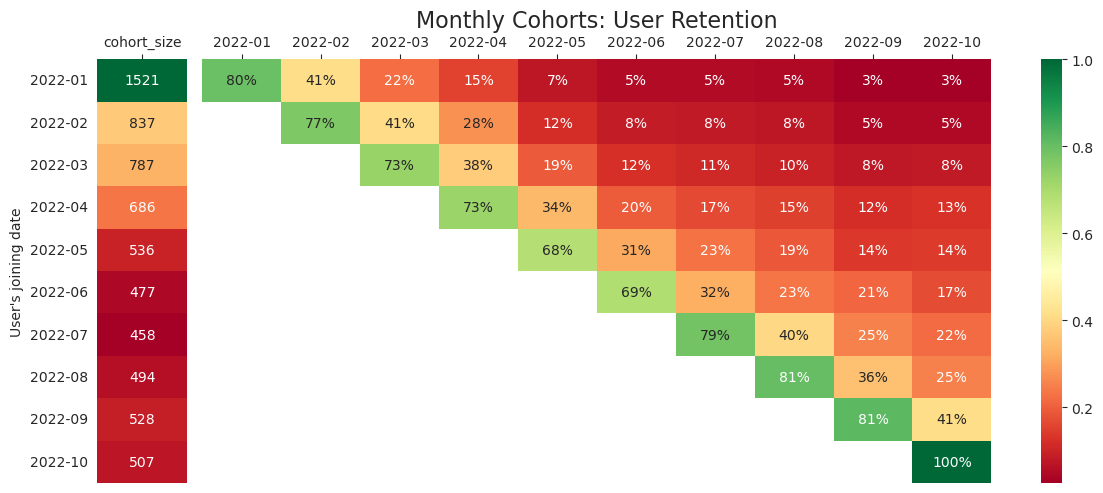

In [178]:
# Since January is the month with more new users (1212), this is the one we will use to train and test the model. 
# Notice first month (period) do not add up to 100% because there are users that didnt do anyhting the month they joined.

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16) 
    ax[1].set(xlabel='', ylabel='')
    ax[1].xaxis.set_label_position('top') # Sets x label name at the top
    ax[1].xaxis.tick_top() # Set x ticks at the top
    
    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g',
                cmap='RdYlGn',
                ax=ax[0])
    ax[0].set_ylabel("User's joining date")
    ax[0].xaxis.tick_top()
    fig.tight_layout()

## Single Cohort Analysis - January 2022
## Machine learning prediction

### Creating cohort and EDA

In [517]:
cohort = '2022-07'
co = ae[ae['user_date_ym'] == cohort][['txn_id', 'user_id', 'txn_date', 'txn_date_ym', 'amount_usd']].reset_index(drop=True)

In [518]:
co_summary = co.groupby('txn_date_ym').agg({'txn_id': 'count', 'user_id': 'nunique', 'amount_usd': 'mean'})
co_summary

,txn_id,user_id,amount_usd
txn_date_ym,,,
2022-07,678,360,77.578968
2022-08,528,183,110.331402
2022-09,298,116,151.986040
2022-10,217,100,156.860415


<AxesSubplot:xlabel='txn_date_ym'>

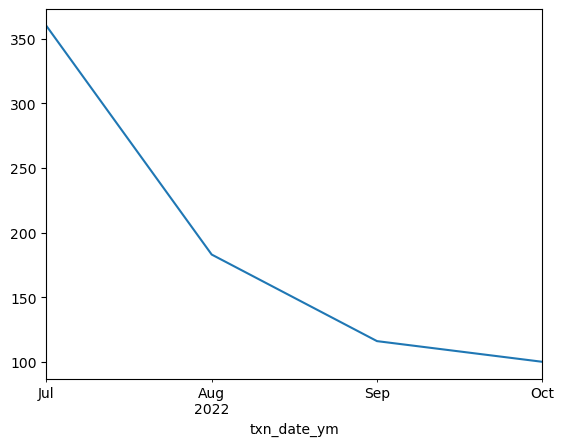

In [519]:
# As expected, the number of customers drops as time goes by.
co_summary['user_id'].plot()

### Split into Train and Test Dataset
What is the probability of a customer to make a purchase in the next 30 days (Classification). 

Train dataset will be first 3 months and test data fourth month.

In [520]:
co.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
0,d8d11cb8-6ca7-4658-bdd8-45527b04a70b,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
1,7cf16160-009e-4755-a515-4e2f224c31f6,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
2,e97231f2-3ad0-4c8c-b85a-a89cb76fbc16,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
3,8dff83c6-6e2a-45e7-a4e0-728459ba0885,912b8668-ae11-97ce-86c6-d879735f101b,2022-10-27,2022-10,136.12
4,163de1fa-6e68-4708-84b8-7a8231d47b6b,33a4a304-4d68-966d-6b16-dd35f71a6685,2022-10-27,2022-10,163.35


In [521]:
# Setting train and test split date
co_final = co[(co['txn_date_ym'] >= '2022-07') & (co['txn_date_ym'] <= '2022-10')]
co_final.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
0,d8d11cb8-6ca7-4658-bdd8-45527b04a70b,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
1,7cf16160-009e-4755-a515-4e2f224c31f6,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
2,e97231f2-3ad0-4c8c-b85a-a89cb76fbc16,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,2022-10-27,2022-10,285.86
3,8dff83c6-6e2a-45e7-a4e0-728459ba0885,912b8668-ae11-97ce-86c6-d879735f101b,2022-10-27,2022-10,136.12
4,163de1fa-6e68-4708-84b8-7a8231d47b6b,33a4a304-4d68-966d-6b16-dd35f71a6685,2022-10-27,2022-10,163.35


In [495]:
cutoff = co_final.txn_date.max() - pd.to_timedelta(27, unit='d')
cutoff

Timestamp('2022-09-30 00:00:00')

In [522]:
# Splitting into train and test. first split, raw.
x_raw = co_final[co_final['txn_date'] < cutoff]
y_raw = co_final[co_final['txn_date'] >= cutoff]
print('Train split %:', round(len(x_raw)/len(co_final), 2), '\nTest split %:', round(len(y_raw)/len(co_final), 2))

Train split %: 0.87 
Test split %: 0.13


### Creating Y true

In [503]:
def create_ytrue(df):
    y = df.groupby('user_id')[['amount_usd']].sum().set_axis(['true_amnt_spent'], axis=1)
    y['is_active'] = 1
    return y

y = create_ytrue(co_final)

In [469]:
y = y_raw.groupby('user_id')[['amount_usd']].sum().set_axis(['true_amnt_spent'], axis=1)
y['is_active'] = 1
y.head()

,true_amnt_spent,is_active
user_id,,
030cc654-203b-46cf-5401-ba9e20b58ac3,5.44,1
04d62c3d-4051-ab58-16f9-75783c31d89e,46.28,1
0aeb37ae-ed27-1744-190d-0a3c9eb0ec39,28.27,1
0bda472d-e3bf-fada-7e95-edd3b4120ae9,3266.99,1
0ce4a72f-08c2-580f-cb18-f22a939f7b4b,10.88,1


### Feature engineering for Train (X) dataset

**Recency**

In [496]:
def recency(df):
    
    def last_buy_days(x, compare_to):
        val = compare_to - x.max()[1]
        return val.days
    
    oldest_date = df.txn_date.max()
    
    grp = df.groupby('user_id')[['user_id', 'txn_date']].apply(lambda x: last_buy_days(x, oldest_date))
    recency = grp.to_frame().set_axis(['recency'], axis=1)
    return recency

recency_df = recency(co_final)
recency_df.head()

,recency
user_id,
002dcaee-fbb6-6642-7503-b8ad895218b2,84
0073aa57-cef5-1872-bbea-20377094ddb3,52
00770baf-7d37-3f8d-fc37-a7c2c6a6c5a1,67
00a9a410-7962-4a9b-9dd3-e50d3231ea41,26
010facb9-6263-5cb3-436c-4efa6feb1819,79


In [471]:
def last_buy_days(x, compare_to):
    val = compare_to - x.max()[1]
    return val.days

In [472]:
oldest_date = x_raw.txn_date.max()

In [473]:
oldest_date

Timestamp('2022-09-29 00:00:00')

In [474]:
grp = x_raw.groupby('user_id')[['user_id', 'txn_date']].apply(lambda x: last_buy_days(x, oldest_date))
recency = grp.to_frame().set_axis(['recency'], axis=1)
recency.head()

,recency
user_id,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,90
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,75
01f3e66b-a475-1b61-5ced-e67b83b997ad,78
0274055b-8807-0774-6416-324c303a7266,35
02a4f922-b220-cba2-dd2e-2c8692115aa8,72


**Frequency**

In [497]:
def frequency(df):
    return df.groupby('user_id')['txn_date'].count().to_frame().set_axis(['frequency'], axis=1)
                                                                         
frequency_df = frequency(co_final)
frequency_df.head()

,frequency
user_id,
002dcaee-fbb6-6642-7503-b8ad895218b2,2
0073aa57-cef5-1872-bbea-20377094ddb3,2
00770baf-7d37-3f8d-fc37-a7c2c6a6c5a1,1
00a9a410-7962-4a9b-9dd3-e50d3231ea41,4
010facb9-6263-5cb3-436c-4efa6feb1819,1


In [476]:
freq = x_raw.groupby('user_id')['txn_date'].count().to_frame().set_axis(['frequency'], axis=1)
freq.head()

,frequency
user_id,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,1
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,1
01f3e66b-a475-1b61-5ced-e67b83b997ad,2
0274055b-8807-0774-6416-324c303a7266,4
02a4f922-b220-cba2-dd2e-2c8692115aa8,1


**Average and Sum spent**

In [498]:
def monetary_value(df):
    return df.groupby('user_id')[['amount_usd']].agg(['sum', 'mean']).set_axis(['price_sum', 'price_mean'], axis=1)

mv_df = monetary_value(co_final)
mv_df.head()

,price_sum,price_mean
user_id,,
002dcaee-fbb6-6642-7503-b8ad895218b2,394.76,197.3800
0073aa57-cef5-1872-bbea-20377094ddb3,25.05,12.5250
00770baf-7d37-3f8d-fc37-a7c2c6a6c5a1,5.44,5.4400
00a9a410-7962-4a9b-9dd3-e50d3231ea41,1170.67,292.6675
010facb9-6263-5cb3-436c-4efa6feb1819,40.84,40.8400


In [478]:
p = x_raw.groupby('user_id')[['amount_usd']].agg(['sum', 'mean']).set_axis(['price_sum', 'price_mean'], axis=1)
p.head()

,price_sum,price_mean
user_id,,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,5.44,5.440
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,5.44,5.440
01f3e66b-a475-1b61-5ced-e67b83b997ad,53.08,26.540
0274055b-8807-0774-6416-324c303a7266,40.82,10.205
02a4f922-b220-cba2-dd2e-2c8692115aa8,27.22,27.220


In [479]:
# Merging X datasets

In [499]:
def df_merger(dfs):
    return pd.concat(dfs, axis=1)

merged = df_merger([recency_df, frequency_df, mv_df])
merged.head()

,recency,frequency,price_sum,price_mean
user_id,,,,
002dcaee-fbb6-6642-7503-b8ad895218b2,84,2,394.76,197.3800
0073aa57-cef5-1872-bbea-20377094ddb3,52,2,25.05,12.5250
00770baf-7d37-3f8d-fc37-a7c2c6a6c5a1,67,1,5.44,5.4400
00a9a410-7962-4a9b-9dd3-e50d3231ea41,26,4,1170.67,292.6675
010facb9-6263-5cb3-436c-4efa6feb1819,79,1,40.84,40.8400


In [481]:
x = pd.concat([recency, freq, p], axis=1)
x.head()

,recency,frequency,price_sum,price_mean
user_id,,,,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,90,1,5.44,5.440
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,75,1,5.44,5.440
01f3e66b-a475-1b61-5ced-e67b83b997ad,78,2,53.08,26.540
0274055b-8807-0774-6416-324c303a7266,35,4,40.82,10.205
02a4f922-b220-cba2-dd2e-2c8692115aa8,72,1,27.22,27.220


### Train test split. Defining X and y datasets.

In [482]:
xy = x.join(y, how='left').fillna(0)
xy.head()

,recency,frequency,price_sum,price_mean,true_amnt_spent,is_active
user_id,,,,,,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,90,1,5.44,5.440,0.0,0.0
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,75,1,5.44,5.440,0.0,0.0
01f3e66b-a475-1b61-5ced-e67b83b997ad,78,2,53.08,26.540,0.0,0.0
0274055b-8807-0774-6416-324c303a7266,35,4,40.82,10.205,0.0,0.0
02a4f922-b220-cba2-dd2e-2c8692115aa8,72,1,27.22,27.220,0.0,0.0


In [483]:
x = xy[['recency', 'frequency', 'price_sum', 'price_mean']]
x.head()

,recency,frequency,price_sum,price_mean
user_id,,,,
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4,90,1,5.44,5.440
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3,75,1,5.44,5.440
01f3e66b-a475-1b61-5ced-e67b83b997ad,78,2,53.08,26.540
0274055b-8807-0774-6416-324c303a7266,35,4,40.82,10.205
02a4f922-b220-cba2-dd2e-2c8692115aa8,72,1,27.22,27.220


In [484]:
y_reg = xy['true_amnt_spent']
y_cls = xy['is_active']
y_cls.head()

user_id
019bcd59-f27c-e3e0-1c8a-82eb6bdd42e4    0.0
01d8a992-1361-a3f8-c1b1-5ab0bf117ab3    0.0
01f3e66b-a475-1b61-5ced-e67b83b997ad    0.0
0274055b-8807-0774-6416-324c303a7266    0.0
02a4f922-b220-cba2-dd2e-2c8692115aa8    0.0
Name: is_active, dtype: float64

In [485]:
# Train Test Split
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(x, y_cls, test_size=0.2, random_state=42)

print(f'Train dataset size: {len(x_train_cls)}\nTest dataset size: {len(x_test_cls)}')

Train dataset size: 354
Test dataset size: 89


### Fitting and Testing the Machine Learning model
### Scikit-Learn Random Forest Classifier

**Fitting Train data**

In [486]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_train_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_train_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.9943502824858758

**Fitting Test data**

In [487]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_test_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_test_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.8314606741573034

In [488]:
pd.concat([x_test_cls.reset_index(drop=False), y_true, y_pred], axis=1)

,user_id,recency,frequency,price_sum,price_mean,y_true,y_pred
0,c6df42c4-99e6-d18e-2437-f1dfa487c0a3,38,1,5.44,5.440000,1.0,0.0
1,4ec4444f-fd18-b122-c269-92407cfe784a,2,2,108.89,54.445000,0.0,1.0
2,268dd040-04eb-f33d-6c01-a2e92b650673,24,3,54.44,18.146667,0.0,0.0
3,d5d67fe7-0ba0-8788-6fa2-c3ce70f09d80,82,2,277.69,138.845000,0.0,0.0
4,26fa1ba9-6709-0373-6be8-c2390025af9b,61,1,5.44,5.440000,0.0,0.0
...,...,...,...,...,...,...,...
84,3605d9bd-eea4-0cfa-7524-6a09a164b4d2,69,1,62.62,62.620000,0.0,0.0
85,324e5d55-511e-9de3-30e1-81dc372437af,70,2,21.77,10.885000,0.0,0.0
86,1e9f0be6-3665-eed4-b0a8-64f661be68f3,61,7,51.72,7.388571,0.0,0.0
87,560a37df-da76-7211-05ab-af06eefa20db,90,1,5.44,5.440000,0.0,0.0


In [489]:
ae[ae['user_id'] == '4ec4444f-fd18-b122-c269-92407cfe784a'].sort_values('txn_date')

,txn_id,txn_date,txn_type,amount_usd,user_id,user_date,txn_date_ym,user_date_ym
8576,098b3306-6741-41b2-9dcc-2a1e57b8ac88,2022-09-25,load using bank card,27.22,4ec4444f-fd18-b122-c269-92407cfe784a,2022-07-09,2022-09,2022-07
8301,ef52c160-e589-4445-a641-23cf732692c2,2022-09-27,load using bank card,81.67,4ec4444f-fd18-b122-c269-92407cfe784a,2022-07-09,2022-09,2022-07


In [500]:
# November Prediction

In [ ]:
model = RandomForestClassifier(random_state=42)

model.fit(merged, y_train_cls)
y_pred = pd.DataFrame(model.predict(merged), columns=['y_pred'])

y_true = pd.DataFrame(y_train_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

In [515]:
y_cls = y['is_active']

user_id
002dcaee-fbb6-6642-7503-b8ad895218b2    1
0073aa57-cef5-1872-bbea-20377094ddb3    1
00770baf-7d37-3f8d-fc37-a7c2c6a6c5a1    1
00a9a410-7962-4a9b-9dd3-e50d3231ea41    1
010facb9-6263-5cb3-436c-4efa6feb1819    1
                                       ..
fc6e01b6-1692-a230-7dd9-8d24f8416f9a    1
fcbf91d6-7644-4085-91e9-3fc742047d53    1
fd6810b5-1739-e9e4-c2fd-ea2faf7ad28e    1
fda2a25f-06ef-aac9-4617-17aee92029c0    1
fe0df573-1f74-db9f-0ba9-dee0adf1a1d5    1
Name: is_active, Length: 494, dtype: int64